<a href="https://colab.research.google.com/github/parimalakettymuthu/MachineLearning-Projects/blob/main/stackExchange_Final_NN_Multilabel_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  !pip install torchtext --upgrade --q
  !pip install torchmetrics --q
  !pip install --quiet torch-lr-finder --q
  !pip install --upgrade wandb --q
  !pip install --gensim --q

  basepath = '/content/drive/My Drive/NLP'
  sys.path.append('/content/drive/My Drive/NLP/custom-functions')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --gensim


In [3]:
#Importing the required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchmetrics
from torchmetrics.classification import MultilabelF1Score, MultilabelHammingDistance
from torchmetrics.functional.classification import multilabel_f1_score,multilabel_hamming_distance

import joblib
import ast
import wandb

from types import SimpleNamespace
from functools import partial
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer as mlb

In [4]:
#Defined the google drive folders for accessing/saving model progress
embeddings_folder = Path(basepath)/ 'assignment7/WordEmbeddings'
data_folder = Path(basepath)/ 'assignment7/MultiLabel_Classification'
model_saving_folder = Path(basepath)/ 'assignment7/NN_MultiLabel_Classification_task3b'


In [5]:
data_cleaned = data_folder/ "df_multilabel_hw_cleaned.joblib"
stackExchange_dataset = joblib.load(data_cleaned)

In [6]:
X = stackExchange_dataset['cleaned_text'].values
y = stackExchange_dataset['Tag_Number'].values

In [7]:
!pip install swifter -qq

In [8]:
import swifter
import ast
stackExchange_dataset['Tag_number_list'] = stackExchange_dataset['Tag_Number'].swifter.apply(lambda x: ast.literal_eval(x))

Pandas Apply:   0%|          | 0/47427 [00:00<?, ?it/s]

In [9]:
y_final = stackExchange_dataset['Tag_number_list'].values

In [10]:
#from sklearn.preprocessing import MultiLabelBinarizer as mlb
y_stackExchange_encoding = mlb().fit_transform(y_final)

In [11]:
from sklearn.model_selection import train_test_split
X_sExchange_train, X_valid_test, y_sExchange_train, y_valid_test = train_test_split(X, y_stackExchange_encoding, test_size=0.4, random_state=42)
X_sExchange_valid, X_sExchange_test, y_sExchange_valid, y_sExchange_test = train_test_split(X_valid_test, y_valid_test, test_size=0.5, random_state=42)

In [12]:
from gensim.models import KeyedVectors
pretrained_sExchange_file = str(embeddings_folder/ "model_stackExchange_CBOW.bin")
sExchange_vectors = KeyedVectors.load(pretrained_sExchange_file)

In [13]:
!pip install torch_lr_finder -qq

In [14]:
from torch_lr_finder import LRFinder
from Trainer_v4 import Trainer
from data_preparation_HW7 import *

In [15]:
from ff_sequential_model_v1 import MLPCustom

#Creating Dataset & Vocab

In [16]:
se_trainset = CustomDataset(X_sExchange_train, y_sExchange_train)
se_validset = CustomDataset(X_sExchange_valid, y_sExchange_valid)
se_testset = CustomDataset(X_sExchange_test, y_sExchange_test)

#Creating stackexchange vocab
stackExchange_vocab = get_vocab(se_trainset, min_freq=2)

In [17]:
pretrained_weights, words_found, words_not_found = get_pretrained_weights(
    vocab=stackExchange_vocab,
    pretrained_vectors=sExchange_vectors,
    embedding_dim = 300,
    )

In [18]:
pretrained_weights.shape

torch.Size([90287, 300])

In [19]:
type(pretrained_weights), words_found, words_not_found

(torch.Tensor, 14664, 75623)

In [20]:
hyperparameters = SimpleNamespace(
    # for model
    EMBED_DIM=300,
    VOCAB_SIZE=len(stackExchange_vocab),
    OUTPUT_DIM=10,
    HIDDEN_SIZES_LIST=[200],
    DPROB_LIST=[0.0],
    NON_LINEARITY=nn.ReLU(),
    BATCH_NORM=False,

    # for training
    INITIALIZATION ='kaiming',
    EPOCHS=50,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    DATASET='IMDB',
    ARCHITECTURE='embed_layer-ffn',

    # for optimizer
    OPTIMIZER='AdamW',
    MOMENTUM = 0,
    NESTEROV = False,
    WEIGHT_DECAY = 0.000,

    # gradient clipping
    CLIP_TYPE='norm',
    CLIP_VALUE=2,

    # early stopping
    EARLY_STOP_PATIENCE=5,

    #scheduler
    SCHEDULER = 'None'
    )

Specify the run name and folder

In [21]:
project_name = 'Regularization_stackExchange_v4'
run_name = 'exp8'
run_folder = model_saving_folder/project_name/run_name
run_folder.mkdir(exist_ok=True, parents=True)
log_frequency = 5

In [22]:
run_folder

PosixPath('/content/drive/My Drive/NLP/assignment7/NN_MultiLabel_Classification_task3b/Regularization_stackExchange_v4/exp8')

In [23]:
# run 1 - based on default initialization
# Notes: Final Learning rate was set to 0.01

# run 2 - add dropout
hyperparameters.LEARNING_RATE = 0.01   
hyperparameters.DPROB_LIST=[0.5] 

# run 3 - remove dropout, add weight decay
hyperparameters.WEIGHT_DECAY = 1
hyperparameters.DPROB_LIST=[0] 

# run 4 - remove dropout, add weight decay
hyperparameters.WEIGHT_DECAY = 0.1

# run 5 - increase batch size to 256
hyperparameters.BATCH_SIZE = 256

# run 6 - One cyucle scheduler
hyperparameters.LEARNING_RATE = 0.001   
hyperparameters.WEIGHT_DECAY = 10
hyperparameters.SCHEDULER='OneCyclicLR'
hyperparameters.SCHEDULER_MAX_LR=0.01
hyperparameters.SCHEDULER_DIV_FACTOR=25
hyperparameters.SCHEDULER_FINAL_DIV_FACTOR=1e3
hyperparameters.EPOCHS = 10

#  run 7 - use pre-trained weights but freeze teh weights - model will 
hyperparameters.USE_PRE_TRAINED_WEIGHTS = True
hyperparameters.FREEZE_PRETRAINED = True

# run 8 - Unfreeze the weights
hyperparameters.FREEZE_PRETRAINED = False

Trainer Configuration

In [25]:
# Fix seed value
Trainer.set_seed()

collate_fn = partial(collate_batch, vocab=stackExchange_vocab)

# Data Loader
train_loader, valid_loader = get_loaders(trainset=se_trainset, validset=se_validset, 
                                         batch_size_=hyperparameters.BATCH_SIZE,
                                         collate_fn=collate_fn)

# cross entropy loss function
loss_function = nn.BCEWithLogitsLoss()

# model
model_stackExchange = MLPCustom(hyperparameters.EMBED_DIM,
                       hyperparameters.VOCAB_SIZE,
                       hyperparameters.HIDDEN_SIZES_LIST,
                       hyperparameters.DPROB_LIST,
                       hyperparameters.OUTPUT_DIM,
                       hyperparameters.NON_LINEARITY,
                       hyperparameters.BATCH_NORM,                       
                       use_pre_trained_weights =hyperparameters.USE_PRE_TRAINED_WEIGHTS,
                       pretrained_weights=pretrained_weights, 
                       freeze_pretrained = hyperparameters.FREEZE_PRETRAINED)

def init_weights(m):
  if type(m) == nn.Linear:
      torch.nn.init.kaiming_normal_(m.weight)
      torch.nn.init.zeros_(m.bias)

# apply initialization recursively  to all modules
if hyperparameters.INITIALIZATION =='kaiming':
    model_stackExchange.apply(init_weights)

# OPTIMIZERS
def get_optimizer():
    if hyperparameters.OPTIMIZER == "SGD":
        optimizer = torch.optim.SGD(
            model_stackExchange.parameters(),
            lr=hyperparameters.LEARNING_RATE,
            momentum=hyperparameters.MOMENTUM,
            nesterov=hyperparameters.NESTEROV,
            weight_decay = hyperparameters.WEIGHT_DECAY
        )
    else:
        optimizer = torch.optim.AdamW(
            model_stackExchange.parameters(), 
            lr=hyperparameters.LEARNING_RATE,
            weight_decay = hyperparameters.WEIGHT_DECAY

        )
    return optimizer

optimizer = get_optimizer()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [26]:
model_stackExchange

MLPCustom(
  (non_linearity): ReLU()
  (embedding): EmbeddingBag(90287, 300, mode='mean')
  (module_list): ModuleList(
    (0): Linear(in_features=300, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=200, out_features=10, bias=True)
  )
)

In [27]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 10
)

Specify Trainer

In [28]:
trainer = Trainer(model=model_stackExchange, optimizer=optimizer,
                  criterion=loss_function, device=device)
# set loaders
trainer.set_loaders(train_loader, valid_loader)

Set Trainer based on Hyperparameters

In [29]:
# Reset Optimizer
trainer.set_optimizer(get_optimizer())

# set metric -- optional
train_metric = MultilabelHammingDistance(num_labels=10)
valid_metric = MultilabelHammingDistance(num_labels=10)
trainer.set_metric(train_metric.to(device), valid_metric.to(device))

# set checkpoint -- OPTIONAL
trainer.set_checkpoint(save_path=run_folder,
                       save_best=True, save_every_n_epochs=5, save_last_epoch=True)

# set early stopping
# trainer.set_early_stopping(patience = hyperparameters.EARLY_STOP_PATIENCE)

# set gradient clipping
trainer.set_gradient_clipping(hyperparameters.CLIP_TYPE, hyperparameters.CLIP_VALUE, norm_type=2)

# set scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(trainer.optimizer, patience=hyperparameters.SCHEDULER_PATIENCE,
#                                           factor=hyperparameters.SCHEDULER_FACTOR)

steps_per_epoch = len(trainer.train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(trainer.optimizer, 
                                                hyperparameters.SCHEDULER_MAX_LR, 
                                                steps_per_epoch=steps_per_epoch,
                                                epochs=hyperparameters.EPOCHS,
                                                div_factor=hyperparameters.SCHEDULER_DIV_FACTOR,
                                                final_div_factor=hyperparameters.SCHEDULER_FINAL_DIV_FACTOR)

trainer.set_lr_scheduler(scheduler=scheduler)

In [30]:
# set wandb -- OPTIONAL
trainer.set_wandb(project_name=project_name,
                  run_name=run_name, config=hyperparameters, log_batch=True, log_frequency=log_frequency)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Sanity Check

In [34]:
trainer.sanity_check(num_classes=2)

Actual loss: 0.6912672449867614
Expected Theoretical loss: 0.6931471805599453


Trainer Model

In [35]:
trainer.train(num_epochs=hyperparameters.EPOCHS, multilabel=True)

Epoch 1/10 - Train Loss: 0.4651, Train Metric: 0.1795, Train Time: 0:01:45.117556
Epoch 1/10 - Val Loss: 0.3143, Val Metric: 0.1284, Val Time: 0:00:09.577450
Current Learning rate is [0.0028130060883050827]

Epoch 2/10 - Train Loss: 0.2493, Train Metric: 0.0956, Train Time: 0:01:42.191049
Epoch 2/10 - Val Loss: 0.2121, Val Metric: 0.0751, Val Time: 0:00:07.805150
Current Learning rate is [0.0076259416939714175]

Epoch 3/10 - Train Loss: 0.2045, Train Metric: 0.0697, Train Time: 0:01:23.398102
Epoch 3/10 - Val Loss: 0.2125, Val Metric: 0.0704, Val Time: 0:00:07.862936
Current Learning rate is [0.009999959858862473]

Epoch 4/10 - Train Loss: 0.2073, Train Metric: 0.0709, Train Time: 0:01:22.124915
Epoch 4/10 - Val Loss: 0.2113, Val Metric: 0.0731, Val Time: 0:00:05.673849
Current Learning rate is [0.009496135200511025]

Epoch 5/10 - Train Loss: 0.2102, Train Metric: 0.0713, Train Time: 0:01:23.961898
Epoch 5/10 - Val Loss: 0.2129, Val Metric: 0.0699, Val Time: 0:00:05.683563
Current Lear

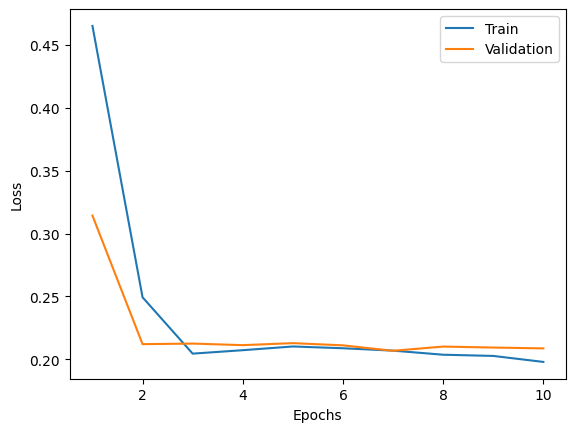

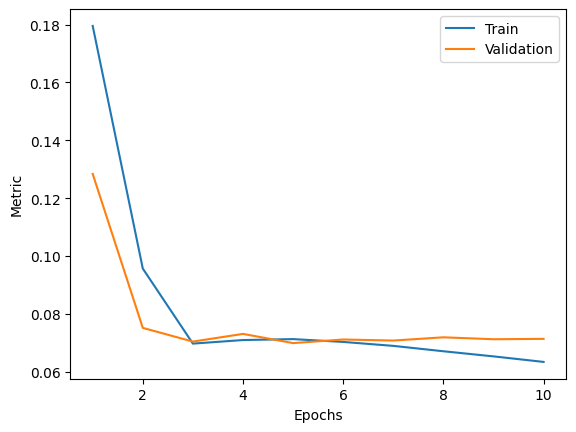

In [36]:
trainer.plot_history()

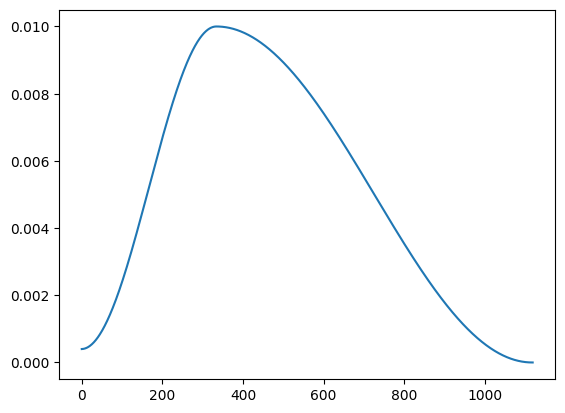

In [38]:
import matplotlib.pyplot as plt
plt.plot([lr for list_ in trainer.learning_rates[1:] for lr in list_ ])

Get Accuracy & Predictions

In [39]:
test_loader = get_test_loaders(se_testset, batch_size_=hyperparameters.BATCH_SIZE,
                               collate_fn=collate_fn)

In [40]:
trainer.timestamp

'2023-04-22_23-23-21'

In [41]:
file = 'checkpoint_' + str(trainer.timestamp) + '_best.pt'
trainer.load_checkpoint(run_folder /file)

Loaded checkpoint from '/content/drive/My Drive/NLP/assignment7/NN_MultiLabel_Classification_task3b/Regularization_stackExchange_v4/exp8/checkpoint_2023-04-22_23-23-21_best.pt'.


In [51]:
# Get the prediction and accuracy for the test dataset
predictions_test, target_test = trainer.predict(
    test_loader, return_targets=True, multilabel=True)
predictions_train, target_train = trainer.predict(
    train_loader, return_targets=True, multilabel=True)
predictions_valid, target_valid = trainer.predict(
    valid_loader, return_targets=True, multilabel=True)

In [52]:
metric = multilabel_hamming_distance
hd_train = metric(predictions_train, target_train, num_labels=10)
hd_valid = metric(predictions_valid, target_valid, num_labels=10)
hd_test = metric(predictions_test, target_test, num_labels=10)


In [53]:
# Print Hammo=imng Distance
print('Test hamming distance', hd_test )
print('Train hamming distance', hd_train )
print('Valid hamming distance', hd_valid )

Test hamming distance tensor(0.0732)
Train hamming distance tensor(0.0631)
Valid hamming distance tensor(0.0708)


In [54]:
metric = multilabel_f1_score
f1_train = metric(predictions_train, target_train, num_labels=10)
f1_valid = metric(predictions_valid, target_valid, num_labels=10)
f1_test = metric(predictions_test, target_test,num_labels=10)

# Print Test Accuracy
print('Test f1score', f1_test * 100)
print('Train f1score', f1_train * 100)
print('Valid f1score', f1_valid * 100)


Test f1score tensor(48.7717)
Train f1score tensor(51.1839)
Valid f1score tensor(49.0083)


In [46]:
print(f1_score(predictions_test.numpy(), target_test.numpy(), average='macro') * 100)
print(f1_score(predictions_train.numpy(), target_train.numpy(), average='macro') * 100)
print(f1_score(predictions_valid.numpy(), target_valid.numpy(), average='macro') * 100)


NameError: ignored

In [55]:
from torchmetrics.functional.classification import multilabel_accuracy

In [56]:
metric = multilabel_accuracy
acc_train = metric(predictions_train, target_train, num_labels=10)
acc_valid = metric(predictions_valid, target_valid, num_labels=10)
acc_test = metric(predictions_test, target_test, num_labels=10)


In [57]:
# Print Hammo=imng Distance
print('Test accuracy', acc_test)
print('Train accuracy', acc_train)
print('Valid accuracy', acc_valid)

Test accuracy tensor(0.9268)
Train accuracy tensor(0.9369)
Valid accuracy tensor(0.9292)


In [58]:
print('Test accuracy', 1- acc_test)
print('Train accuracy', 1- acc_train)
print('Valid accuracy', 1- acc_valid)

Test accuracy tensor(0.0732)
Train accuracy tensor(0.0631)
Valid accuracy tensor(0.0708)
